In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alanhermawan","key":"2cb8bd98be2732332a972020374fa050"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [3]:
!kaggle datasets download -d nickwong64/corn2015-2017

  0% 0.00/7.09k [00:00<?, ?B/s]
100% 7.09k/7.09k [00:00<00:00, 15.1MB/s]


In [4]:
!mkdir corn2015-2017
!unzip corn2015-2017.zip -d corn2015-2017
!ls corn2015-2017

Archive:  corn2015-2017.zip
  inflating: corn2015-2017/corn2013-2017.txt  
  inflating: corn2015-2017/corn2015-2017.txt  
  inflating: corn2015-2017/corn_OHLC2013-2017.txt  
corn2013-2017.txt  corn2015-2017.txt  corn_OHLC2013-2017.txt


In [5]:
import pandas as pd
import numpy as np

# library untuk lvisualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# library untuk analisis time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# library yang digunakan untuk forecasting
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [6]:
df = pd.read_csv("/content/corn2015-2017/corn2013-2017.txt",sep=',',header=None, names=['date','price'])

In [7]:
df.head()

,date,price
0,2013-01-06,7.794975
1,2013-01-13,7.863400
2,2013-01-20,8.234920
3,2013-01-27,8.186260
4,2013-02-03,8.317480


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    248 non-null    object 
 1   price   248 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.0+ KB


In [9]:
df.shape

(248, 2)

In [10]:
df.isnull().sum()

date     0
price    0
dtype: int64

In [11]:
df['date'] = pd.to_datetime(df['date'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    248 non-null    datetime64[ns]
 1   price   248 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.0 KB


In [13]:
df.set_index("date",inplace=True)

In [14]:
df.index.freq='W'

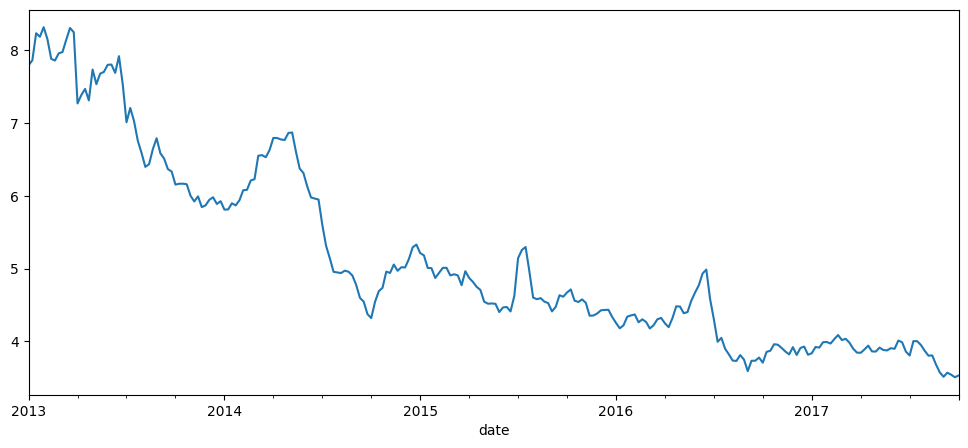

In [15]:
df['price'].plot(figsize=(12,5));

Berdasarkan grafik tersebut, dapat disimpulkan jika harga jagung mengalami penurunan

In [16]:
df.head()

,price
date,
2013-01-06,7.794975
2013-01-13,7.863400
2013-01-20,8.234920
2013-01-27,8.186260
2013-02-03,8.317480


In [17]:
df.index.min(), df.index.max()

(Timestamp('2013-01-06 00:00:00', freq='W-SUN'),
 Timestamp('2017-10-01 00:00:00', freq='W-SUN'))

In [18]:
train = df.iloc[:170]
test = df.iloc[171:]

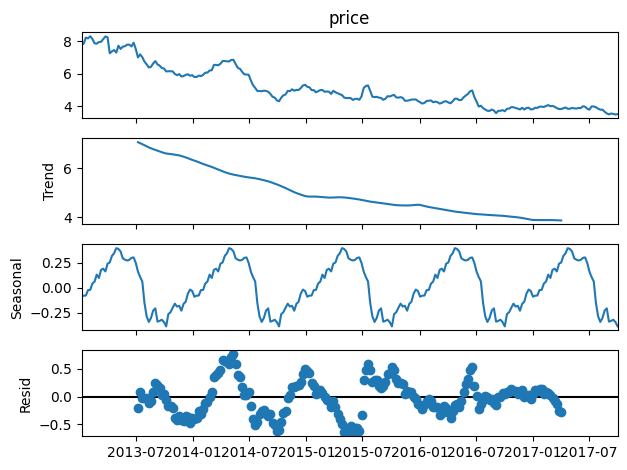

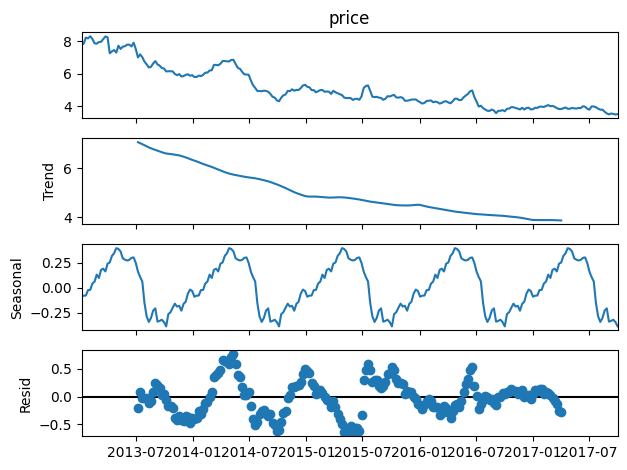

In [19]:
decompose_add = seasonal_decompose(df['price'])
decompose_add.plot()

In [20]:
diff_df = df.diff()
diff_df.head()

,price
date,
2013-01-06,NaN
2013-01-13,0.068425
2013-01-20,0.371520
2013-01-27,-0.048660
2013-02-03,0.131220


In [21]:
diff_df.dropna(inplace=True)

<Axes: xlabel='date'>

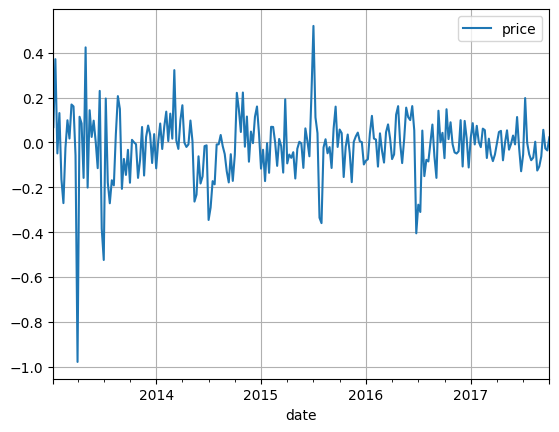

In [22]:
diff_df.plot(grid=True)

In [23]:
result = adfuller(diff_df)
# The result is a tuple that contains various test statistics and p-values
# You can access specific values as follows:
adf_statistic = result[0]
p_value = result[1]

# Print the results
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')

ADF Statistic: -13.496765258501243
p-value: 3.0312210481240657e-25


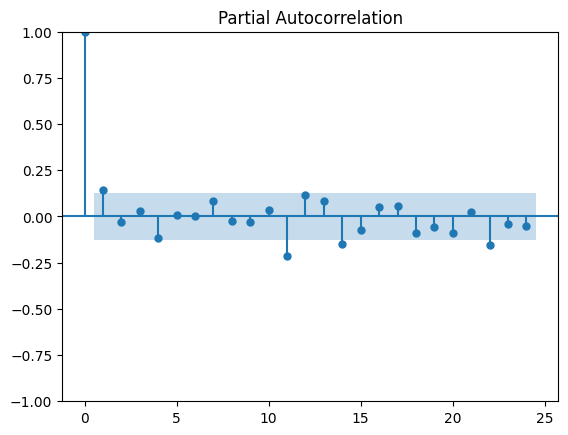

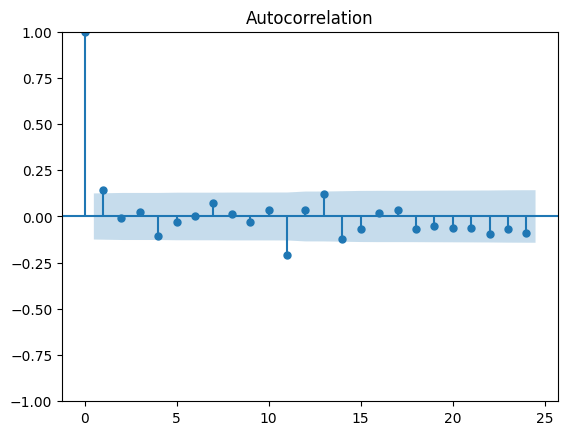

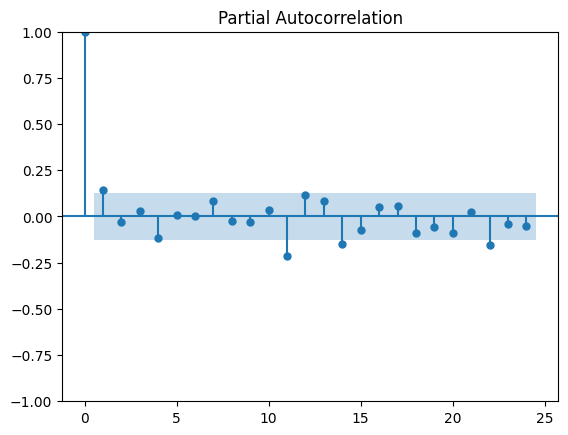

In [24]:
plot_acf(diff_df)
plot_pacf(diff_df)

# Single Exponential Smoothing

In [25]:
single_exp = SimpleExpSmoothing(train).fit()
single_exp_train_pred = single_exp.fittedvalues
single_exp_test_pred = single_exp.forecast(77)

In [26]:
df.shape

(248, 1)

<Axes: xlabel='date'>

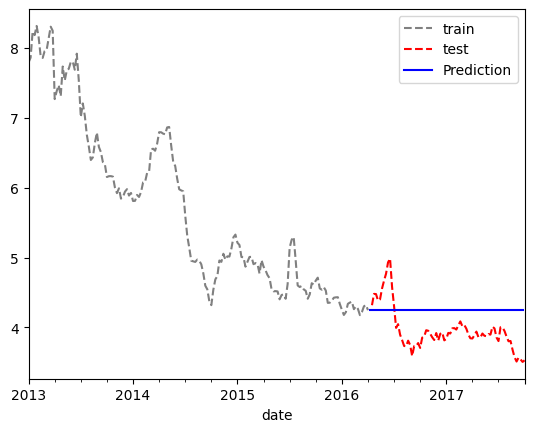

In [27]:
train['price'].plot(style='--', color='gray', legend=True, label='train')
test['price'].plot(style='--', color='r', legend=True, label='test')
single_exp_test_pred.plot(color='b', legend=True, label='Prediction')

In [28]:
Train_RMSE_SES = mean_squared_error(train, single_exp_train_pred)**0.5
Test_RMSE_SES = mean_squared_error(test, single_exp_test_pred)**0.5
Train_MAPE_SES = mean_absolute_percentage_error(train, single_exp_train_pred)
Test_MAPE_SES = mean_absolute_percentage_error(test, single_exp_test_pred)

print('Train RMSE :',Train_RMSE_SES)
print('Test RMSE :', Test_RMSE_SES)
print('Train MAPE :', Train_MAPE_SES)
print('Test MAPE :', Test_MAPE_SES)

Train RMSE : 0.16140010141419225
Test RMSE : 0.41554115341252534
Train MAPE : 0.018756005557876605
Test MAPE : 0.09890883033731582


# Double Exponential Smoothing

In [29]:
double_exp = ExponentialSmoothing(train, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()
double_exp_train_pred = double_exp.fittedvalues
double_exp_test_pred = double_exp.forecast(77)

<Axes: xlabel='date'>

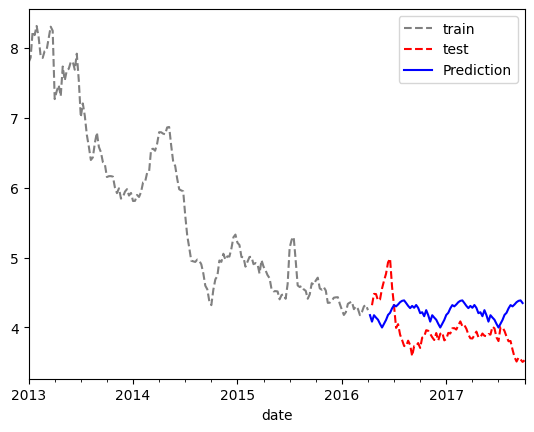

In [30]:
train['price'].plot(style='--', color='gray', legend=True, label='train')
test['price'].plot(style='--', color='r', legend=True, label='test')
double_exp_test_pred.plot(color='b', legend=True, label='Prediction')

In [31]:
Train_RMSE_DES = mean_squared_error(train, double_exp_train_pred)**0.5
Test_RMSE_DES = mean_squared_error(test, double_exp_test_pred)**0.5
Train_MAPE_DES = mean_absolute_percentage_error(train, double_exp_train_pred)
Test_MAPE_DES = mean_absolute_percentage_error(test, double_exp_test_pred)

print('Train RMSE :',Train_RMSE_DES)
print('Test RMSE :', Test_RMSE_DES)
print('Train MAPE :', Train_MAPE_DES)
print('Test MAPE :', Test_MAPE_DES)

Train RMSE : 0.16205098371914398
Test RMSE : 0.4488396674833522
Train MAPE : 0.020458390748657466
Test MAPE : 0.1016007247389691


# ARIMA

In [32]:
ar = ARIMA(train, order=(15,1,15)).fit()
ar_train_pred = ar.fittedvalues
ar_test_pred = ar.forecast(77)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='date'>

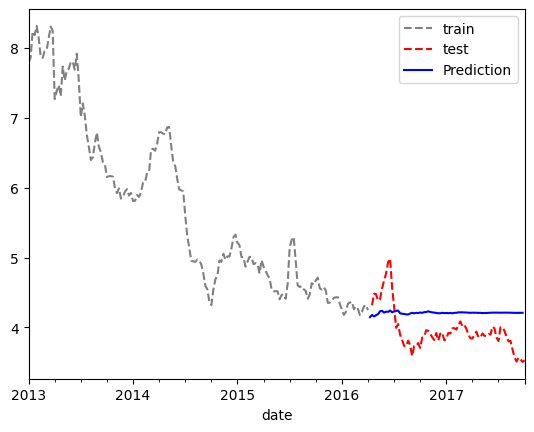

In [33]:
train['price'].plot(style='--', color='gray', legend=True, label='train')
test['price'].plot(style='--', color='r', legend=True, label='test')
ar_test_pred.plot(color='b', legend=True, label='Prediction')

In [34]:
Train_RMSE_AR = mean_squared_error(train, ar_train_pred)**0.5
Test_RMSE_AR = mean_squared_error(test, ar_test_pred)**0.5
Train_MAPE_AR = mean_absolute_percentage_error(train, ar_train_pred)
Test_MAPE_AR = mean_absolute_percentage_error(test, ar_test_pred)

print('Train RMSE :',Train_RMSE_AR)
print('Test RMSE :', Test_RMSE_AR)
print('Train MAPE :', Train_MAPE_AR)
print('Test MAPE :', Test_MAPE_AR)

Train RMSE : 0.6153128426935569
Test RMSE : 0.38981683508614867
Train MAPE : 0.02442687290853558
Test MAPE : 0.09223393707251747


# Perbandingan Algoritma

In [35]:
comparision_df = pd.DataFrame(data=[
    ['Single Exp Smoothing', Test_RMSE_SES, Test_MAPE_SES],
    ['Double Exp Smoothing', Test_RMSE_DES, Test_MAPE_DES],
    ['ARIMA', Test_RMSE_AR, Test_MAPE_AR]
    ],
    columns=['Model', 'RMSE', 'MAPE'])
comparision_df.set_index('Model', inplace=True)

In [36]:
comparision_df.sort_values(by='RMSE')

,RMSE,MAPE
Model,,
ARIMA,0.389817,0.092234
Single Exp Smoothing,0.415541,0.098909
Double Exp Smoothing,0.448840,0.101601


In [37]:
import pickle
pickle.dump(ar, open('forecast-corn-ar.sav','wb'))